## Testing the pyEMMA API

In [1]:
import pyemma
pyemma.__version__

'2.1'

Now we import a few general packages that we need to start with. The following imports basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import matplotlib.pylab as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Now we import the pyEMMA package that we will be using in the beginning: the coordinates package. This package contains functions and classes for reading and writing trajectory files, extracting order parameters from them (such as distances or angles), as well as various methods for dimensionality reduction and clustering.

The shortcuts module is a bunch of functions specific to this workshop - they help us to visualize some of our results. Some of them might become part of the pyemma package once they are more mature.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma import config

In [4]:
# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

shortcuts = {'average_by_state': average_by_state, 'avg_by_set': avg_by_set}

In [5]:
import glob
trajfiles = sorted(glob.glob('./*/05*nc'))
for file in trajfiles:
    print("%s\n" % file)
topfile = "./test.pdb"

./bertha1-WT-ff14SB/05_Prod_0000-0050ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0050-0100ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0100-0150ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0150-0200ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0200-0250ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0250-0300ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0300-0350ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0350-0400ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0400-0450ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0450-0500ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-autoimaged.nc

./bertha1-WT-ff14SB/05_Prod_0500-0550ns_WT-ff14SB_25Awatsalt_hmr.nc_stripped-aut

In [6]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.add_chi1_torsions(cossin=True)

In [7]:
inp = coor.source(trajfiles, feat)


Obtaining file info: 100% (244/244) [##############################] eta 00:01 |

In [8]:
print("Number of trajectories: %s" % inp.number_of_trajectories())
print("Aggregate simulation time: %.2f ns" % (inp.n_frames_total() * 0.02))
print("Number of dimensions: %s" % inp.dimension())

Number of trajectories: 244
Aggregate simulation time: 16800.00 ns
Number of dimensions: 2390


## TICA and clustering
So we would like to first reduce our dimension by throwing out the ‘uninteresting’ ones and only keeping the ‘relevant’ ones. But how do we do that?

It turns out that a really good way to do that if you are interesting in the slow kinetics of the molecule - e.g. for constructing a Markov model, is to use the time-lagged independent component analysis (TICA) [2]. Amongst linear methods, TICA is optimal in its ability to approximate the relevant slow coordinates / reaction coordinates from MD simulation [3], and therefore it’s ideal to construct Markov models.

In [9]:
tica_obj = coor.tica(inp, lag=100)

calculate mean+cov: 100% (8176/8176) [#############################] eta 00:01 |

In [11]:
Y = tica_obj.get_output()[0]

getting output of TICA: 100% (244/244) [###########################] eta 00:01 |

TypeError: not all arguments converted during string formatting

By default, TICA will choose a number of output dimensions to cover 95% of the kinetic variance and scale the output to produce a kinetic map. In this case we retain **575** dimensions, which is a lot but note that they are scaled by eigenvalue, so it’s mostly the first dimensions that contribute.

In [31]:
print("Projected data shape: (%s,%s)" % (Y.shape[0], Y.shape[1]))

Projected data shape: (2500,575)


array([  4.78546917e-01,   1.15171218e+00,   1.33347392e+00, ...,
         1.72825352e+04,   1.72826328e+04,   1.72827617e+04], dtype=float32)

Retained dimensions: 575


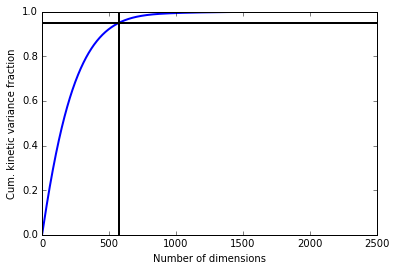

In [32]:
print('Retained dimensions: %s' % tica_obj.dimension())
plot(tica_obj.cumvar, linewidth=2)
plot([tica_obj.dimension(), tica_obj.dimension()], [0, 1], color='black', linewidth=2)
plot([0, Y.shape[0]], [0.95, 0.95], color='black', linewidth=2)
xlabel('Number of dimensions'); ylabel('Cum. kinetic variance fraction')

The TICA object has a number of properties that we can extract and work with. We have already obtained the projected trajectory and wrote it in a variable Y that is a matrix of size (103125 x 2). The rows are the MD steps, the 2 columns are the independent component coordinates projected onto. So each columns is a trajectory. Let us plot them:

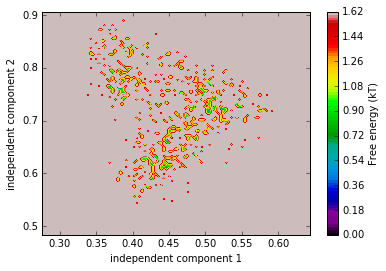

In [17]:
mplt.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1])
xlabel('independent component 1'); ylabel('independent component 2')

A particular thing about the IC’s is that they have zero mean and variance one. We can easily check that:

In [36]:
print("Mean values: %s" % np.mean(Y[0], axis = 0))
print("Variances: %s" % np.var(Y[0], axis = 0))

Mean values: -0.0202599
Variances: 0.405257


The small deviations from 0 and 1 come from statistical and numerical issues. That’s not a problem. Note that if we had set kinetic_map=True when doing TICA, then the variances would not be 1 but rather the square of the corresponding TICA eigenvalue.

TICA is a special transformation because it will project the data such that the autocorrelation along the independent components is as slow as possible. The eigenvalues of the TICA transform are the values of these autocorrelations at the chosen lag time (here 100). We can even interpret them in terms of relaxation timescales:

In [20]:
print(-100/np.log(tica_obj.eigenvalues[:5]))

[ 58916.3390982   49176.41514982  34933.41607058  32727.40154084
  29415.61528081]


We will see more timescales later when we estimate a Markov model, and there will be some differences. For now you should treat these numbers as a rough guess of your molecule’s timescales, and we will see later that this guess is actually a bit too fast. The timescales are relative to the 10 ns saving interval, so we have 

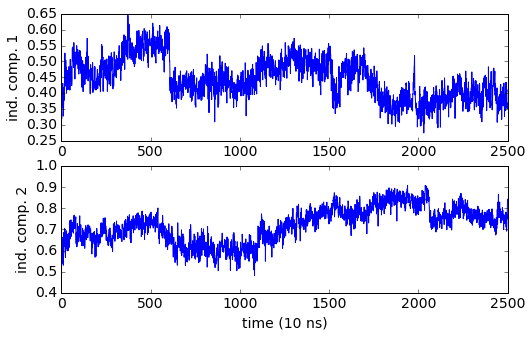

In [34]:
subplot2grid((2,1),(0,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y[:,1])
ylabel('ind. comp. 2')
xlabel('time (10 ns)')

In [37]:
tica_obj.chunksize

1000

AttributeError: 'TICA' object has no attribute 'lagtimes'

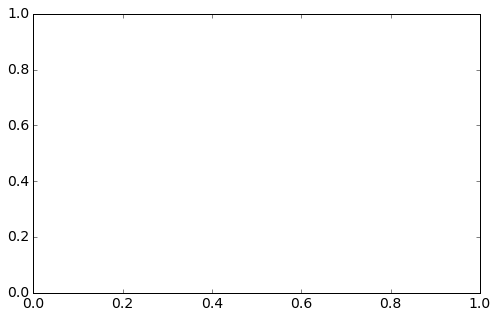

In [56]:
mplt.plot_implied_timescales(tica_obj)